# Formatting NYU Depth
> from http://dl.caffe.berkeleyvision.org/nyud.tar.gz

In [1]:
from PIL import Image
from utils import *
from fastcore.all import *
from scipy.io import loadmat
import numpy as np
from fastdownload import FastDownload

# Fix original dataset
> export segmentation masks from matlab to png

In [2]:
URL = "http://dl.caffe.berkeleyvision.org/nyud.tar.gz"

In [3]:
def untar_data(url, c_key='data', force_download=False):
    "Download `url` and extract"
    d = FastDownload(base="data")
    return d.get(url, force=force_download, extract_key=c_key)

In [ ]:
dataset_path = untar_data(URL, force_download=True)

In [46]:
rgb_path     = dataset_path/"data/images"
depth_path   = dataset_path/"data/depth"
seg_path     = dataset_path/"segmentation"

let's read those pesky `.mat` files

In [53]:
img_path = rgb_path.ls()[0]

def get_tuple(img_path):
    _seg_path = seg_path/(img_path.with_suffix(".mat")).name
    seg = loadmat(_seg_path)
    return Image.open(img_path), Image.open(depth_path/img_path.name), seg["segmentation"]

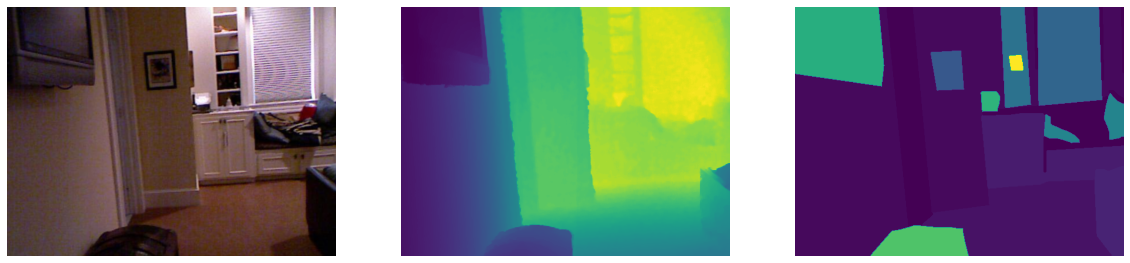

In [57]:
show_images(get_tuple(img_path), figsize=(20,10))

In [58]:
img, depth, seg = get_tuple(img_path)

In [61]:
np.array(depth)

array([[ 848,  849,  849, ..., 3764, 3773, 3780],
       [ 848,  848,  848, ..., 3760, 3763, 3767],
       [ 848,  848,  848, ..., 3758, 3759, 3759],
       ...,
       [1013, 1013, 1014, ..., 2284, 2281, 2282],
       [1013, 1013, 1015, ..., 2279, 2279, 2281],
       [1013, 1013, 1015, ..., 2279, 2270, 2279]], dtype=int32)

In [64]:
seg_pil = Image.fromarray(seg)

In [66]:
seg_pil.save(dataset_path/"mask.png")

In [76]:
def save_mask(fname, dest=dataset_path/"masks"):
    out_path = (Path(dest) / fname.name).with_suffix(".png")
    seg_mask_array = loadmat(fname)["segmentation"]
    seg_pil = Image.fromarray(seg_mask_array)
    seg_pil.save(str(out_path))

In [77]:
seg_path.ls()[0]

Path('nyud_github/segmentation/img_6004.mat')

In [78]:
save_mask(seg_path.ls()[0])

In [79]:
from tqdm.notebook import tqdm

In [80]:
for fname in tqdm(seg_path.ls()):
    save_mask(fname)

  0%|          | 0/1449 [00:00<?, ?it/s]

## Log fixed DS to wandb

In [82]:
import wandb

In [85]:
wandb.init(project="NYU", entity="hydranet")

In [89]:
at = wandb.Artifact("NYU_depth_V2", type="dataset")

In [90]:
at.add_dir("NYU_depth_V2")

wandb: Adding directory to artifact (./NYU_depth_V2)... Done. 2.1s


In [91]:
wandb.log_artifact(at, "NYU_depth_V2")

In [92]:
wandb.finish()

## Create a Table

In [148]:
wandb.init(project="NYU", entity="hydranet")
at = wandb.use_artifact("NYU_depth_V2:latest", type="dataset")

In [149]:
dataset_dir = at.download()

wandb: Downloading large artifact NYU_depth_V2:latest, 655.04MB. 4356 files... Done. 0:0:0


In [151]:
images = (Path(dataset_dir)/"images").ls()

In [152]:
images[0:4]

(#4) [Path('artifacts/NYU_depth_V2:v0/images/img_6115.png'),Path('artifacts/NYU_depth_V2:v0/images/img_6101.png'),Path('artifacts/NYU_depth_V2:v0/images/img_5408.png'),Path('artifacts/NYU_depth_V2:v0/images/img_6129.png')]

In [153]:
def get_tuple(img_path, dataset_dir=dataset_dir):
    dataset_dir = Path(dataset_dir)
    depth_path = dataset_dir / f"depth/{img_path.name}"
    mask_path  = dataset_dir / f"masks/{img_path.name}"
    return tuple(Image.open(f) for f in [img_path, depth_path, mask_path])

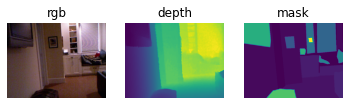

In [154]:
image, depth, mask = get_tuple(images[0])
show_images((image, depth, mask), titles=["rgb", "depth", "mask"])

Let's get the colormaps right before creating the table

In [155]:
depth_arr = np.array(depth)
depth_arr.min(), depth_arr.max()

(846, 4447)

In [156]:
from matplotlib import cm

def to_cm(image, cmap="viridis"):
    image = np.array(image)
    scaled_image = image/image.max()
    return Image.fromarray(np.uint8(getattr(cm, cmap)(scaled_image)*255))

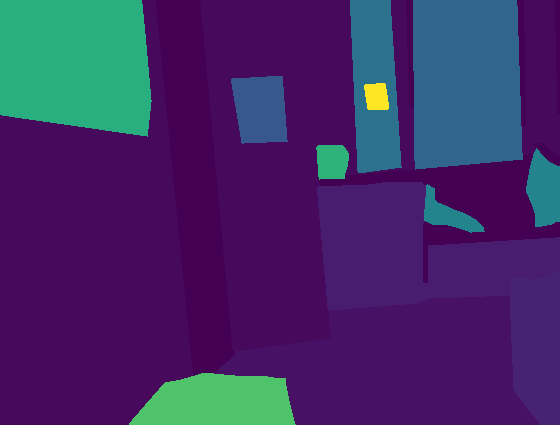

In [157]:
to_cm(mask, "viridis")

In [160]:
ds_table = wandb.Table(columns=["image", "depth", "mask"])

In [161]:
for fname in images:
    image, depth, mask = get_tuple(fname, dataset_dir)
    ds_table.add_data(wandb.Image(image), wandb.Image(to_cm(depth)), wandb.Image(to_cm(mask)))

In [162]:
wandb.log({"NYU_V2":ds_table})

In [163]:
wandb.finish()